## Combinbing Images

Create pseudo foveated mongrels by combining mongrels at different eccentricities

In [162]:
# read in 3 mongrels
import cv2
import matplotlib.pyplot as plt
import numpy as np

base_directory = './60_uniform_overlap'
image_number = 19
eccentricities = [0,150,300,450]

image_name = str(image_number).zfill(12)

./coco_test/000000000019.jpg


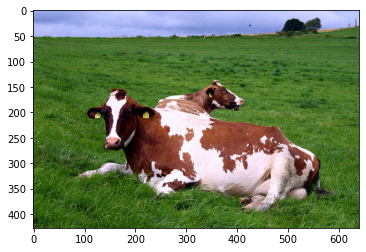

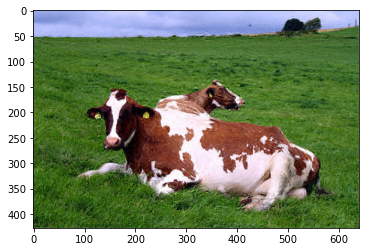

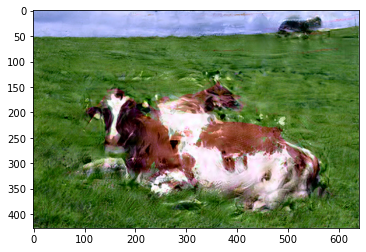

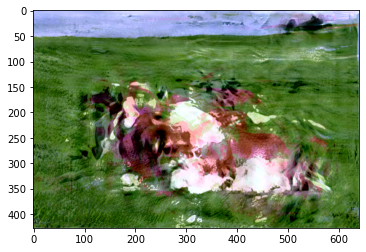

In [163]:
def readin_mongrels(eccentricities_list):
    imgs = []
    
    #original image
    original_fname = f'./coco_test/{image_name}.jpg'
    print(original_fname)
    ori_img = cv2.imread(original_fname)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    imgs.append(ori_img)
    plt.imshow(ori_img)
    plt.show()
    
    #eccentricities
    for e in eccentricities_list[1:]:
        mongrel_fname = f'{base_directory}/{image_name}_X{e}_YNaN_2022-08-09_uniform_60olap_{e}/mongrelized_{image_name}_uniform_60olap_{e}.png'
        mong = cv2.imread(mongrel_fname)
        mong = cv2.cvtColor(mong, cv2.COLOR_BGR2RGB)
        imgs.append(mong)
        #print(mong)
        plt.imshow(mong)
        plt.show()
    return(imgs)

mongs = readin_mongrels(eccentricities)

(427, 640, 3)
0 0 0 16


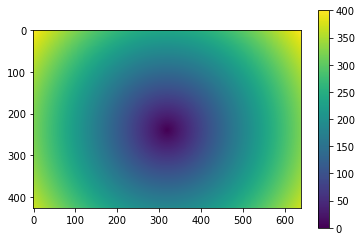

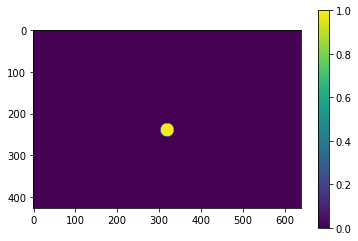

1 150 16 150


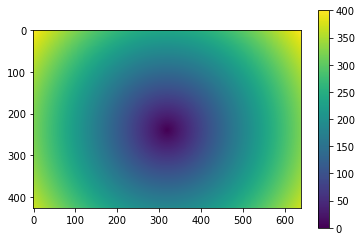

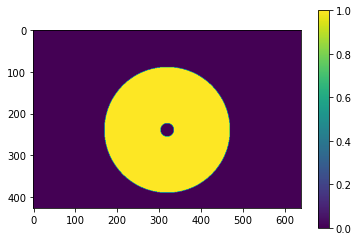

2 300 150 300


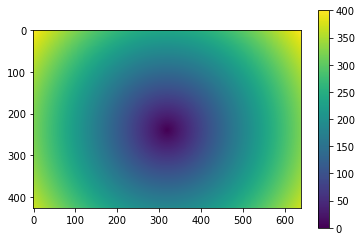

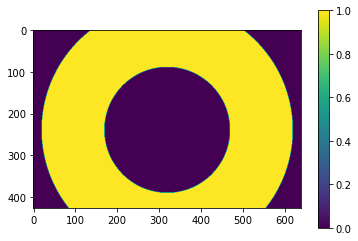

3 450 300 450


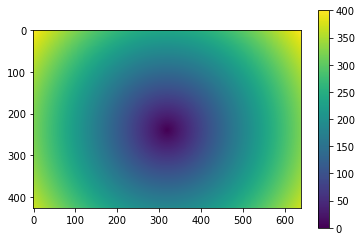

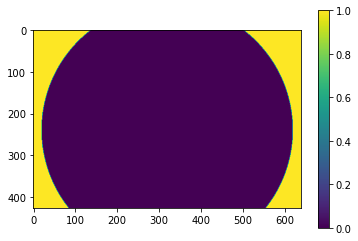

In [164]:
foveation_location = (320,240)
fovea_size = 16

img_shape = np.shape(mongs[0])

# Calculate the indices from the image
y, x = np.indices(img_shape[:-1])
num_bins = np.min(img_shape[:-1])

normalized = ((x-foveation_location[0]),(y-foveation_location[1]))
r = np.hypot(normalized[0], normalized[1])

pseudo_foveated = np.zeros_like(mongs[0])
print(pseudo_foveated.shape)

for i, ecc in enumerate(eccentricities):
    if(i==0):
        min_ecc = 0
        max_ecc = fovea_size
    elif(i==1):
        min_ecc = fovea_size
        max_ecc = eccentricities[i]
    else:
        min_ecc = eccentricities[i-1]
        max_ecc = eccentricities[i]
        
    print(i,ecc, min_ecc, max_ecc)

    #don't calculate corners
    ecc_mask = np.where((r>=min_ecc) & (r<max_ecc), True, False)
    
    
    plt.imshow(r)
    plt.colorbar()
    plt.show()
    
    plt.imshow(1*ecc_mask)
    plt.colorbar()
    plt.show()
    
    pseudo_foveated[ecc_mask,:] = mongs[i][ecc_mask,:]

#     # number of bins should be equivalent to the number of bins along the shortest axis of the image.
#     if(bin_in_log):
#         bin_edges = np.histogram_bin_edges(np.log(r), num_bins)
#         bin_edges = np.exp(bin_edges)
#     else:
#         bin_edges = np.histogram_bin_edges(r,num_bins)
    
#     r_binned = np.digitize(r, bin_edges)
#     binmean = np.zeros(num_bins)
#     for i in range(num_bins):
#         #if(len(r_binned[r_binned==i+1])>0):
#         binmean[i] = np.mean(image[np.where(r_binned==i+1)])
#         #else:
#         #    binmean[i] = 0
#     bin_centers = bin_edges[:-1] + ((bin_edges[1]-bin_edges[0])/2)
#     bin_centers = (bin_centers/np.max(bin_centers))*nyquist

True

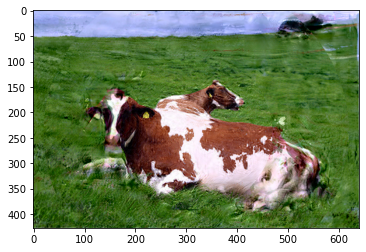

In [165]:
plt.imshow(pseudo_foveated)
pseudo_foveated = cv2.cvtColor(pseudo_foveated, cv2.COLOR_RGB2BGR)
cv2.imwrite(f'pseudo_foveated_{image_name}.png',pseudo_foveated)

In [140]:
r.shape

(500, 332)

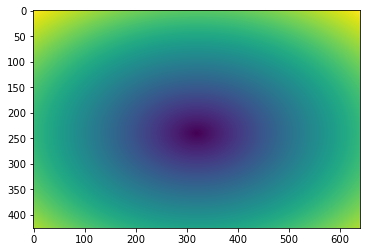

In [55]:
plt.imshow(r.reshape(img_shape[:-1]))